해당 Kaggle 대회 링크   
https://www.kaggle.com/competitions/playground-series-s4e7/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# 데이터 불러오기
train_data = pd.read_csv('/Users/jongwoom1pro/Coding/개인프로젝트/insurance-cross-sell-prediction/data/train.csv')
test_data = pd.read_csv('/Users/jongwoom1pro/Coding/개인프로젝트/insurance-cross-sell-prediction/data/test.csv')

In [3]:
display(train_data.shape, test_data.shape)

print("train data의 비율:",len(train_data)/(len(train_data) + len(test_data)))

(11504798, 12)

(7669866, 11)

train data의 비율: 0.599999979139139


In [4]:
train_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


1. 결측치 확인

In [5]:
display(train_data.isnull().sum(), test_data.isnull().sum())


id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

2. 변수 타입 확인

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


3. 종속변수 분포 확인
- imbalanced problem 확인   

In [7]:
display(train_data['Response'].value_counts())

print("1의 비율:",len(train_data[train_data['Response'] == 1])/len(train_data))
print("0의 비율:",len(train_data[train_data['Response'] == 0])/len(train_data))

Response
0    10089739
1     1415059
Name: count, dtype: int64

1의 비율: 0.12299729208631043
0의 비율: 0.8770027079136896



    긍정(1) 12.3%, 부정(0) 87.7% 로 종속 변수가 불균형한 것을 확인할 수 있다.
      
- 이를 해결하기 위해 SMOTE를 통해 데이터 증강을 시도해볼 필요 있음.     
- 평가지표로는 Accuracy가 아닌 F1 score를 사용해야 함.   

In [8]:
train_data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1


4. 독립변수 타입 확인


- 범주형 변수   
   
    id - 고객의 ID 번호    
   
    Gender - 성별 (남성, 여성)     

    Driving_License - 운전면허증 보유 여부 (0: 보유하지 않음, 1: 보유함)

    Region_Code - 고객의 지역 코드

    Previously_Insured - 이전에 보험 가입 여부 (0: 가입하지 않음, 1: 가입함)

    Vehicle_Age - 차량 연식 (0-1년, 1-2년, 2년 이상)  

    Vehicle_Damage - 차량 손상 여부 (Yes: 손상, No: 손상 없음)

    Policy_Sales_Channel - 보험 상품 판매 채널 코드

- 연속형 변수   
    
    Age - 고객의 나이   

    Annual_Premium - 연간 보험료

    vintage - 고객 계약 유지 기간


- 종속변수
   
    Response -  목표 변수, 고객이 보험에 가입할지 여부 (0: 가입하지 않음, 1: 가입함) 


In [24]:
# 각 범주/연속형 변수 칼럼 새로운 변수에 정리
numerical = ['Age', 'Annual_Premium', 'Vintage']
categorical = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']

5. 연속형 변수 분포 시각화

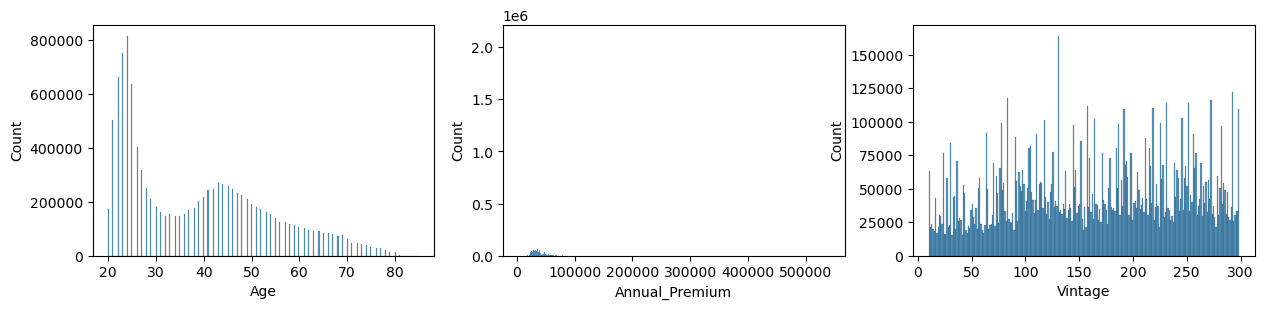

In [46]:
# 데이터 연속형 변수 분포 시각화
plt.figure(figsize=(15, 3))
for i, col in enumerate(train_data[numerical]):
    plt.subplot(1, 3, i+1)
    sns.histplot(x=col, data=train_data)

6. 범주형 변수 분포 시각화

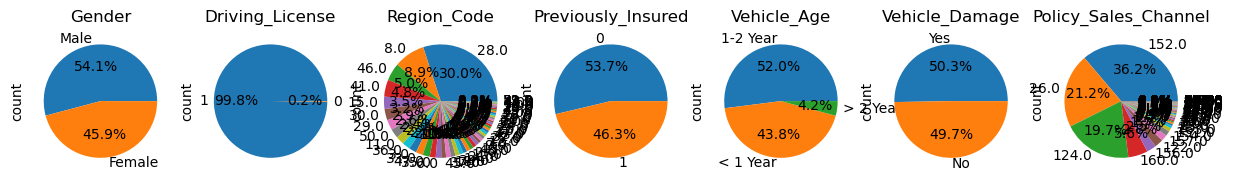

In [42]:
# 범주형 변수 2개씩 묶어서 subplot으로 분포 시각화 확인(파이차트)

fig, axes = plt.subplots(1,7,figsize=(15,15))
for i, ax in enumerate(axes.flat):
    train_data[categorical[i]].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
    ax.set_title(categorical[i])

7. 다중공선성 문제 확인   
- 변수 간 상관관계 확인

    → 모델링의 목적이 "예측"인 경우에는 다중공선성 문제가 크게 중요하지 않음, 그러나 "해석"이 목적인 경우에는 고려해야 함

<Axes: >

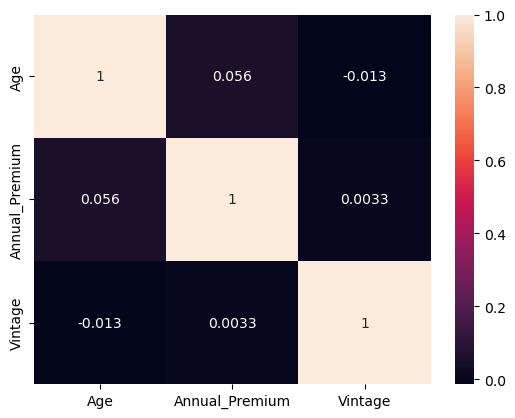

In [47]:
# 다중공선성 문제 확인
corr = train_data[numerical].corr()
sns.heatmap(corr, annot=True)

In [49]:
# vif 계산
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(train_data[numerical])
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,VIF
0,const,14.789059
1,Age,1.003366
2,Annual_Premium,1.003199
3,Vintage,1.000193
